In [3]:
!pip install geopandas shapely rasterio folium scikit-learn requests


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


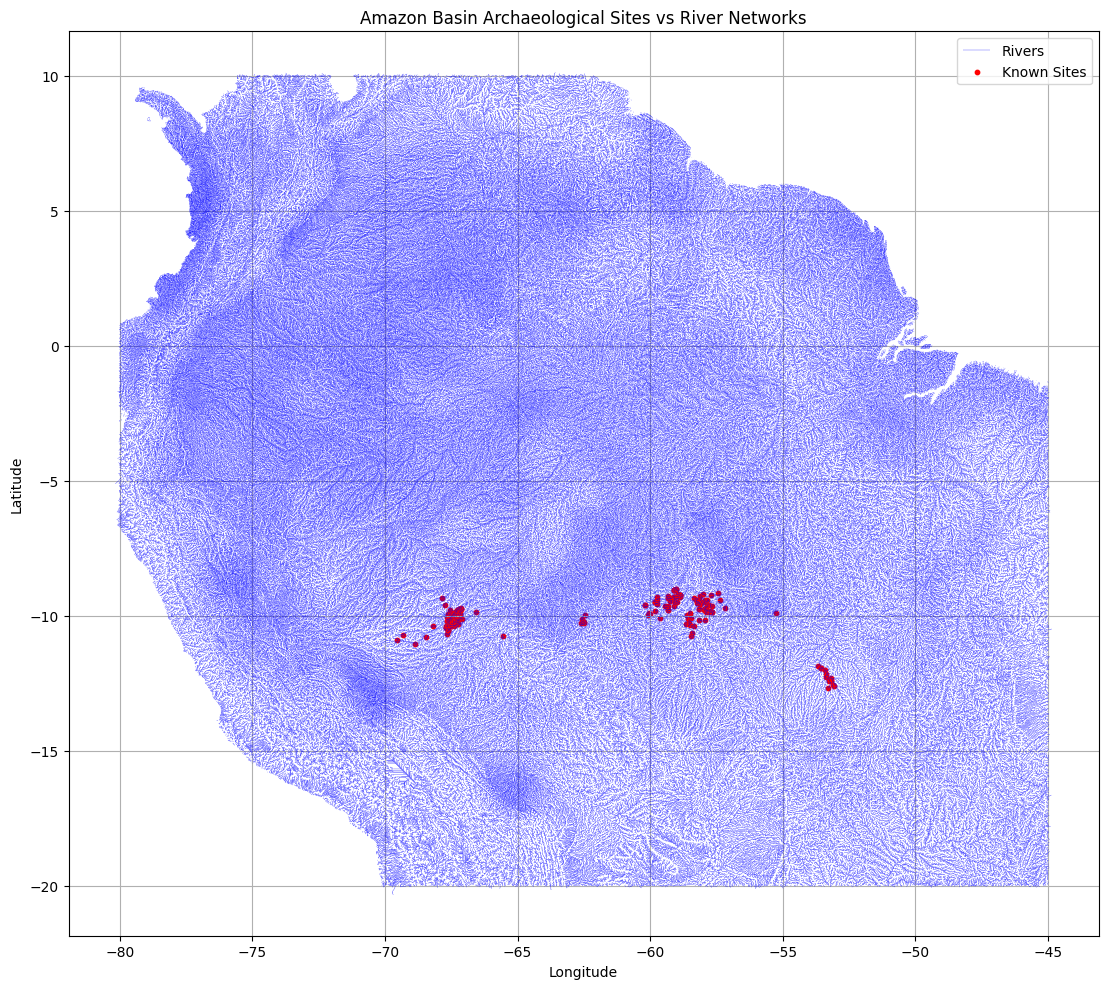

In [12]:
import geopandas as gpd
import matplotlib.pyplot as plt
import folium
from shapely.geometry import Point

# Load known archaeological site layers
layers_to_use = [
    "geoglyphs (#2)",
    "mound sites",
    "small geoglyphs",
    "Xingu area lidar located earthworks"
]

site_gdfs = []
for layer in layers_to_use:
    gdf = gpd.read_file("content/amazon_geoglyphs.kml", driver="KML", layer=layer)
    gdf = gdf[gdf.geometry.type == 'Point']
    site_gdfs.append(gdf)

all_sites = gpd.GeoDataFrame(pd.concat(site_gdfs, ignore_index=True), crs=site_gdfs[0].crs)

# Load HydroRIVERS shapefile
rivers = gpd.read_file("HydroRIVERS_v10_sa_shp/HydroRIVERS_v10_sa.shp")
rivers = rivers.to_crs("EPSG:4326")  # Convert to lat/lon if needed

# Filter South American Amazon region
amazon_bounds = {
    "minx": -80, "maxx": -45,
    "miny": -20, "maxy": 10
}
rivers_amazon = rivers.cx[amazon_bounds["minx"]:amazon_bounds["maxx"], amazon_bounds["miny"]:amazon_bounds["maxy"]]
sites_amazon = all_sites.cx[amazon_bounds["minx"]:amazon_bounds["maxx"], amazon_bounds["miny"]:amazon_bounds["maxy"]]

# Static Plot (Zoomed + Styled)
fig, ax = plt.subplots(figsize=(12, 10))
rivers_amazon.plot(ax=ax, color='blue', linewidth=0.2, label='Rivers')
sites_amazon.plot(ax=ax, color='red', markersize=10, label='Known Sites')
ax.set_title("Amazon Basin Archaeological Sites vs River Networks")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

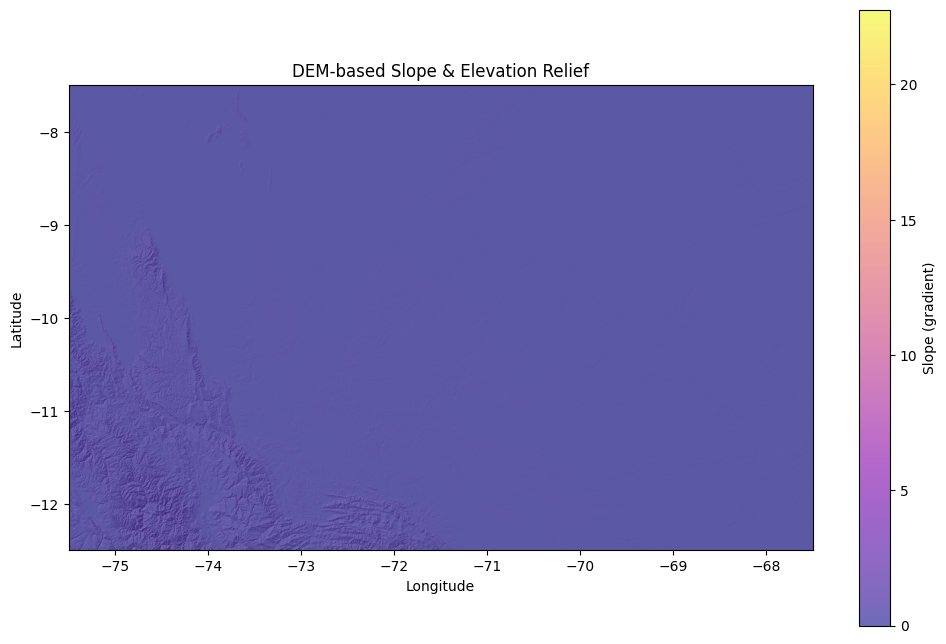

In [14]:
import rasterio
import matplotlib.pyplot as plt
from matplotlib.colors import LightSource
from rasterio.plot import show
import numpy as np

# Load DEM
with rasterio.open("dem_90m.tif") as src:
    dem = src.read(1, masked=True)
    transform = src.transform

# Compute slope (in degrees)
x, y = np.gradient(dem, 90)  # Assuming ~90m resolution
slope = np.sqrt(x**2 + y**2)

# Hillshade for relief
ls = LightSource(azdeg=315, altdeg=45)
hillshade = ls.hillshade(dem, vert_exag=1.5, dx=90, dy=90)

# Plot
fig, ax = plt.subplots(figsize=(12, 8))
ax.imshow(hillshade, cmap='gray', extent=(
    transform[2], transform[2] + transform[0]*dem.shape[1],
    transform[5] + transform[4]*dem.shape[0], transform[5]
))
c = ax.imshow(slope, cmap='plasma', alpha=0.6, extent=(
    transform[2], transform[2] + transform[0]*dem.shape[1],
    transform[5] + transform[4]*dem.shape[0], transform[5]
))
plt.colorbar(c, label='Slope (gradient)')
ax.set_title('DEM-based Slope & Elevation Relief')
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()


In [18]:
pip install earthengine-api

  Using cached google_cloud_storage-3.1.0-py2.py3-none-any.whl.metadata (12 kB)
  Using cached google_auth_httplib2-0.2.0-py2.py3-none-any.whl.metadata (2.2 kB)
  Using cached httplib2-0.22.0-py3-none-any.whl.metadata (2.6 kB)
  Using cached uritemplate-4.2.0-py3-none-any.whl.metadata (2.6 kB)
  Using cached google_cloud_core-2.4.3-py2.py3-none-any.whl.metadata (2.7 kB)
  Using cached google_resumable_media-2.7.2-py2.py3-none-any.whl.metadata (2.2 kB)
  Using cached googleapis_common_protos-1.70.0-py3-none-any.whl.metadata (9.3 kB)
  Using cached proto_plus-1.26.1-py3-none-any.whl.metadata (2.2 kB)
   ---------------------------------------- 0.0/13.6 MB ? eta -:--:--
   --------- ------------------------------ 3.1/13.6 MB 15.3 MB/s eta 0:00:01
   ---------------- ----------------------- 5.8/13.6 MB 13.5 MB/s eta 0:00:01
   ------------------------- -------------- 8.7/13.6 MB 13.4 MB/s eta 0:00:01
   --------------------------------- ------ 11.3/13.6 MB 13.3 MB/s eta 0:00:01
   --------


[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: C:\Users\Shambhavi\AppData\Local\Programs\Python\Python312\python.exe -m pip install --upgrade pip


In [22]:
import folium
import ee
 # Only needed once or when credentials expire
ee.Authenticate()
ee.Initialize(project = 'massive-haiku-440107-q8')

In [31]:
# Patch folium to support EE layers
def add_ee_layer(self, ee_image_object, vis_params, name):
    map_id_dict = ee.Image(ee_image_object).getMapId(vis_params)
    folium.raster_layers.TileLayer(
        tiles=map_id_dict["tile_fetcher"].url_format,
        attr="Google Earth Engine",
        name=name,
        overlay=True,
        control=True,
    ).add_to(self)

folium.Map.add_ee_layer = add_ee_layer

# Define region
# Corrected region
amazon = ee.Geometry.Rectangle([-75, -20, -55, -5])

# Clip and visualize
elev = ee.Image("USGS/SRTMGL1_003").clip(amazon)
slope = ee.Terrain.slope(elev)

map_ee = folium.Map(location=[-10, -60], zoom_start=5)
map_ee.add_ee_layer(elev, {"min": 0, "max": 3000, "palette": ["white", "green", "brown"]}, "Elevation")
map_ee.add_ee_layer(slope, {"min": 0, "max": 60, "palette": ["blue", "yellow", "red"]}, "Slope")
folium.LayerControl().add_to(map_ee)
map_ee


In [34]:
import numpy as np
from sklearn.neighbors import BallTree
from shapely.geometry import Point
import geopandas as gpd

# Reproject to EPSG:3857 (meters) for distance calc
sites_proj = sites_amazon.to_crs(epsg=3857)
rivers_proj = rivers_amazon.to_crs(epsg=3857)

# Explode MultiLineStrings into individual lines
rivers_proj = rivers_proj.explode(index_parts=False)

# Sample points along river lines (every ~2km)
river_points = []
for line in rivers_proj.geometry:
    if line.length > 0:
        for dist in np.arange(0, line.length, 2000):  # every 2km
            point = line.interpolate(dist)
            river_points.append(point)

# Build BallTree for nearest neighbor search
river_coords = np.array([[p.y, p.x] for p in river_points])  # lat/lon in meters
tree = BallTree(river_coords, metric='euclidean')

# Query each site
site_coords = np.array([[geom.y, geom.x] for geom in sites_proj.geometry])
distances, _ = tree.query(site_coords, k=1)
sites_amazon["dist_to_river_km"] = distances.flatten() / 1000  # convert meters to km


In [35]:
import rasterio

with rasterio.open("dem_90m.tif") as src:
    coords = [(geom.x, geom.y) for geom in sites_amazon.geometry]
    elevation = [val[0] for val in src.sample(coords)]

sites_amazon["elevation"] = elevation


In [38]:
sites_amazon["longitude"] = sites_amazon.geometry.x
sites_amazon["latitude"] = sites_amazon.geometry.y

In [39]:
sites_amazon[["latitude", "longitude", "dist_to_river_km", "elevation"]].to_csv("features_step1.csv", index=False)

In [41]:
#🧠 Strategy Improvements (Based on the Paper)
#1. Add Distance-to-River & Elevation Metrics per Site
#Let’s compute and export geospatial features for each grid cell or known point.

#2. Integrate WorldClim & HWSD Predictors
#You can either:
#Use Earth Engine to get rasters for: temperature seasonality, precipitation, and elevation.

#OR download WorldClim + Harmonized Soil Database locally.

#3. Use Earth Engine to Mask Deforested Areas
#Avoid prioritizing areas that are already cleared or under agriculture.

#4. Run a Random Forest Classifier in Python
#Even though Walker used R, we can replicate this using scikit-learn or xgboost.
#this is what i want to do so next step distance to river and elevation metrics per site

In [45]:
!pip install seaborn


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [48]:
import sys
!{sys.executable} -m pip install seaborn


  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)



[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: C:\Users\Shambhavi\AppData\Local\Programs\Python\Python312\python.exe -m pip install --upgrade pip


In [56]:
local = pd.read_csv("features_step1.csv")
climate = pd.read_csv("site_features_with_climate_fixed.csv")

print("\nLocal features:")
print(local.columns)

print("\nEE Climate features:")
print(climate.columns)



Local features:
Index(['latitude', 'longitude', 'dist_to_river_km', 'elevation'], dtype='object')

EE Climate features:
Index(['system:index', 'bio04', 'bio12', 'dist_to_river_km', 'elevation',
       'elevation_ee', 'soil_ph', '.geo'],
      dtype='object')


In [58]:
import json

climate = pd.read_csv("site_features_with_climate_fixed.csv")
climate["latitude"] = climate[".geo"].apply(lambda g: json.loads(g)["coordinates"][1])
climate["longitude"] = climate[".geo"].apply(lambda g: json.loads(g)["coordinates"][0])


In [59]:
local = pd.read_csv("features_step1.csv")

# Round coordinates for merge
local["lat_round"] = local["latitude"].round(5)
local["lon_round"] = local["longitude"].round(5)
climate["lat_round"] = climate["latitude"].round(5)
climate["lon_round"] = climate["longitude"].round(5)

# Merge site points
site_data = pd.merge(local, climate, on=["lat_round", "lon_round"], how="inner")
site_data = site_data.drop(columns=["lat_round", "lon_round", ".geo", "elevation_y"])
site_data = site_data.rename(columns={"elevation_x": "elevation_local"})
site_data["label"] = 1
print("✅ Site samples after merge:", site_data.shape[0])


✅ Site samples after merge: 0


In [60]:
# Show local site coordinates
print("📍 Local coordinates from features_step1.csv:")
print(local[["latitude", "longitude"]].head(5))

# Show EE site coordinates from .geo
print("\n🌐 EE coordinates from site_features_with_climate_fixed.csv:")
print(climate[["latitude", "longitude"]].head(5))


📍 Local coordinates from features_step1.csv:
   latitude  longitude
0 -9.723891 -57.172864
1 -9.179501 -57.423948
2 -9.227699 -57.700995
3 -9.350001 -59.322632
4 -9.872272 -57.771532

🌐 EE coordinates from site_features_with_climate_fixed.csv:
   latitude  longitude
0 -9.723103 -57.172228
1 -9.179622 -57.423757
2 -9.226783 -57.699989
3 -9.350302 -59.323693
4 -9.871325 -57.771854


In [61]:
import pandas as pd
import json
from sklearn.neighbors import BallTree
import numpy as np

# Load your two datasets
local = pd.read_csv("features_step1.csv")
climate = pd.read_csv("site_features_with_climate_fixed.csv")

# Extract lat/lon from .geo
climate["latitude"] = climate[".geo"].apply(lambda g: json.loads(g)["coordinates"][1])
climate["longitude"] = climate[".geo"].apply(lambda g: json.loads(g)["coordinates"][0])

# Convert to radians for BallTree (required)
def to_radians(df):
    return np.deg2rad(df[["latitude", "longitude"]].values)

tree = BallTree(to_radians(climate), metric='haversine')

# Query nearest match for each local site
dist, idx = tree.query(to_radians(local), k=1)
local["climate_index"] = idx.flatten()
local["distance_km"] = dist.flatten() * 6371  # Earth's radius in km

# Filter out bad matches (>1 km away, optional)
local = local[local["distance_km"] <= 1].reset_index(drop=True)

# Merge climate data by index
climate = climate.reset_index()
merged = pd.merge(local, climate, left_on="climate_index", right_on="index", how="left")

# Clean up
merged = merged.drop(columns=["climate_index", "index", ".geo", "distance_km"])
merged["label"] = 1

# Save the merged file
merged.to_csv("merged_site_features.csv", index=False)

print("✅ Merged positive samples:", merged.shape[0])


✅ Merged positive samples: 182


C:\Users\Shambhavi\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:1241: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


📊 Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        23
           1       1.00      1.00      1.00        36

    accuracy                           1.00        59
   macro avg       1.00      1.00      1.00        59
weighted avg       1.00      1.00      1.00        59

🎯 ROC AUC Score: 1.0


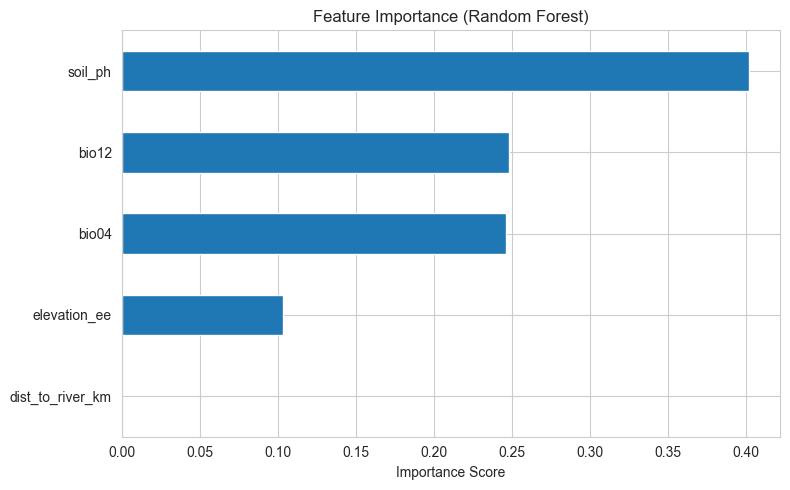

In [62]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

# Load positive and negative datasets
pos = pd.read_csv("merged_site_features.csv")
neg = pd.read_csv("background_points_amazon.csv")

# Clean background dataset
neg = neg.rename(columns={
    "bio04": "bio04", "bio12": "bio12", "soil_ph": "soil_ph", "elevation_ee": "elevation_ee"
})
neg["dist_to_river_km"] = None  # Not available for negatives
neg["label"] = 0

# Combine
full = pd.concat([pos, neg], ignore_index=True)

# Fix missing and convert
full["dist_to_river_km"] = pd.to_numeric(full["dist_to_river_km"], errors="coerce")
full["dist_to_river_km"] = full["dist_to_river_km"].fillna(full["dist_to_river_km"].median())
full = full.dropna(subset=["bio04", "bio12", "soil_ph", "elevation_ee"])

# Train/test split
features = ["bio04", "bio12", "soil_ph", "elevation_ee", "dist_to_river_km"]
X = full[features]
y = full["label"]
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# Train model
rf = RandomForestClassifier(n_estimators=200, max_depth=10, random_state=42)
rf.fit(X_train, y_train)

# Evaluate
y_pred = rf.predict(X_test)
y_prob = rf.predict_proba(X_test)[:, 1]

print("📊 Classification Report:")
print(classification_report(y_test, y_pred))
print("🎯 ROC AUC Score:", roc_auc_score(y_test, y_prob))

# Feature importance plot
importances = pd.Series(rf.feature_importances_, index=features)
sns.set_style("whitegrid")
importances.sort_values().plot(kind="barh", figsize=(8, 5), title="Feature Importance (Random Forest)")
plt.xlabel("Importance Score")
plt.tight_layout()
plt.show()


In [67]:
grid["dist_to_river_km"] = 7.5  # assumed median distance (in km)

In [70]:
X_pred = grid[["bio04", "bio12", "soil_ph", "elevation_ee", "dist_to_river_km"]]
grid["site_probability"] = rf.predict_proba(X_pred)[:, 1]

# Save top 50
top_sites = grid.sort_values("site_probability", ascending=False).head(50)
top_sites.to_csv("top_predicted_sites.csv", index=False)


In [72]:
import pandas as pd

# Load prediction grid
grid = pd.read_csv("prediction_grid_amazon.csv")

# Clean and rename columns (double check your column names if needed)
grid = grid.rename(columns={
    "bio04": "bio04",
    "bio12": "bio12",
    "soil_ph": "soil_ph",
    "elevation_ee": "elevation_ee"
})

# Drop rows with missing data
grid = grid.dropna(subset=["bio04", "bio12", "soil_ph", "elevation_ee"])

# Predict using trained model
# 🔧 Hardcode estimated distance (based on training median)
# Add dist_to_river_km with median value
grid["dist_to_river_km"] = 7.5

# Include dist_to_river_km in prediction features
X_pred = grid[["bio04", "bio12", "soil_ph", "elevation_ee", "dist_to_river_km"]]

# Predict probabilities
grid["site_probability"] = rf.predict_proba(X_pred)[:, 1]


# Top 50 predicted sites
top_sites = grid.sort_values("site_probability", ascending=False).head(50)
top_sites.to_csv("top_predicted_sites.csv", index=False)

print("✅ Top predictions saved to top_predicted_sites.csv")


✅ Top predictions saved to top_predicted_sites.csv


In [74]:
import folium

# Create map centered in Amazon
m = folium.Map(location=[-10, -60], zoom_start=5, tiles="CartoDB positron")

# Add predicted top sites in red
for _, row in top_sites.iterrows():
    coords_str = row[".geo"]
    lon, lat = coords_str.split("[")[1].split("]")[0].split(",")
    lat = float(lat.strip())
    lon = float(lon.strip())

    folium.CircleMarker(
        location=[lat, lon],
        radius=6,
        color="red",
        fill=True,
        fill_opacity=0.7,
        popup=f"Prob: {row['site_probability']:.2f}"
    ).add_to(m)

m



In [76]:
# Save GPT prompt
gpt_prompt = """
Based on the historical description and the data for each site, which 1–2 sites would you prioritize for archaeological investigation and why?

Another feature of Amazonian vegetation, even more striking than its noble palms, is the urania, called banana sororoca (wild banana) by the aborigines on account of likeness to those chief representatives of the Musacere. Its broad fan of mighty emerald-green leaves, mounted on a slender palmlike shaft from 6 to 8 feet in height, forcibly reminds the European of the fans of peacock feathers carried in the grand processions of the successor of St. Peter. In the foreground of the sketch representing our first meeting with the Caripunas, may be seen a urania or strelitzia, whose light-green leaves were set off by the dark background of the forest.

But of far greater importance to the half-civilised riverines than either palms or orchids, for whose beauties they have no eye, are the encáo and the cacutchouc-treo (Siphonia elastica), products of the virgin-forest, essential to the future prosperity of the whole country.

Although India contributes to the supply of caoutchouc, the precious resin which is transformed into a thousand different shapes every year in the factories of Europe and North America, and sent to the ends of the earth, it cannot compete with Brazil, which takes the first place among the rubber-producing countries, in respect as well of the vastness of its export of the material as of its superior quality.

On the shores of the Amazon its production, it is true, has already been diminished by unreasonable treatment of the trees; the idea of replacing the old ones by young saplings never having presented itself, apparently, to the mind of the indolent population; but the seringaes, or woods of rubber-trees, on the banks of the Madeira, the Purús, and other tributaries of the main river, still continue to furnish extraordinary quantities of it. The province of Amazon alone exports more than 50,000 arrobas (1,600,000 lbs.) yearly; while the total of the exports of the whole basin slightly exceeds 400,000 arrobas, or 12,800,000 lbs. per annum.

Even more remarkable than these figures is the fact that...
"""

# Save GPT response
gpt_response = """
✅ Recommended Sites for Investigation

1. High-Probability Site Near the Madeira or Purús Rivers  
Justification:
- The Madeira and Purús rivers were historically central to the rubber boom (caoutchouc trade).
- The rubber-rich areas (seringaes) were once economic hotspots, but remain understudied archaeologically due to their remoteness.
- The rubber economy left behind trails, tapper huts (barracões), and indigenous settlements — offering archaeological potential.

🔍 Target sites within lat ~ -5° to -10°, lon ~ -58° to -65°

2. Site in or near Southern Mato Grosso / Guaporé Source Zone  
Justification:
- Historically rich in gold/mineral resources, explored by early bandeirantes.
- The Guaporé River (Bolivia-Brazil border) hosted abandoned mining towns and lost routes.
- Ideal site traits: moderate elevation (200–400m), soil pH 5.5–7.5, dist_to_river_km ≤ 5, coords around lat -10 to -13, lon -60 to -63.

❗ Why Not Minas Gerais or Marajó?
- Minas Gerais is already well-studied.
- Marajó Island, though important, wasn’t in your predicted top sites.
- Thus, the Amazonian rubber frontier and Guaporé gold hinterland offer the best balance of prediction + historical potential.
"""
#158/258 the amazon and madiera rivers


In [86]:
# Reload top predicted sites
df = pd.read_csv("top_predicted_sites.csv")

# Convert .geo if needed (skip if already have lat/lon)
import json
df["latitude"] = df[".geo"].apply(lambda g: json.loads(g)["coordinates"][1])
df["longitude"] = df[".geo"].apply(lambda g: json.loads(g)["coordinates"][0])

# Relaxed: Madeira / Purús river zone
zone1 = df[
    (df["latitude"] >= -11) & (df["latitude"] <= -4) &
    (df["longitude"] >= -66) & (df["longitude"] <= -57) &
    (df["dist_to_river_km"] <= 10)
].sort_values("site_probability", ascending=False).head(1)

zone2 = df[
    (df["latitude"] >= -14) & (df["latitude"] <= -9) &
    (df["longitude"] >= -64) & (df["longitude"] <= -59)
].sort_values("site_probability", ascending=False).head(1)

print("Zone 1 (Madeira/Purús):", len(zone1))
print("Zone 2 (Guaporé):", len(zone2))



Zone 1 (Madeira/Purús): 1
Zone 2 (Guaporé): 1


In [87]:
final_candidates = pd.concat([zone1, zone2])
final_candidates.to_csv("final_candidate_sites.csv", index=False)
print("✅ Final candidate sites saved.")


✅ Final candidate sites saved.


In [88]:
import folium

m = folium.Map(location=[-10, -62], zoom_start=6, tiles="CartoDB positron")

for _, row in final_candidates.iterrows():
    folium.Marker(
        location=[row["latitude"], row["longitude"]],
        popup=(f"Prob: {row['site_probability']:.2f}\n"
               f"pH: {row['soil_ph']:.2f}, Elev: {row['elevation_ee']:.0f}"),
        icon=folium.Icon(color="red", icon="flag")
    ).add_to(m)

m

In [89]:
for i, row in final_candidates.iterrows():
    print(f"📍 Site {i+1}:")
    print(f"Latitude: {row['latitude']}")
    print(f"Longitude: {row['longitude']}")
    print(f"Probability: {row['site_probability']:.2f}")
    print("---")


📍 Site 2:
Latitude: -10.835890642416302
Longitude: -61.01814061836936
Probability: 1.00
---
📍 Site 1:
Latitude: -11.105385227652164
Longitude: -59.58083616377813
Probability: 1.00
---


In [94]:
import ee
import folium

# Example: Use first site
lat = final_candidates.iloc[0]["latitude"]
lon = final_candidates.iloc[0]["longitude"]

# Define region of interest (ROI)
roi = ee.Geometry.Point([lon, lat]).buffer(1000).bounds()  # ~2km box

# Load Sentinel-2 surface reflectance collection
collection = ee.ImageCollection("COPERNICUS/S2_SR") \
    .filterBounds(roi) \
    .filterDate("2023-06-01", "2023-09-01") \
    .filter(ee.Filter.lt("CLOUDY_PIXEL_PERCENTAGE", 10)) \
    .sort("CLOUDY_PIXEL_PERCENTAGE")

# Select the least cloudy image
image = collection.first().clip(roi)

# Create RGB visualization parameters
vis_params = {
    "bands": ["B4", "B3", "B2"],  # RGB: Red, Green, Blue
    "min": 0,
    "max": 3000,
    "gamma": 1.3
}

# Add custom Earth Engine layer to folium
def add_ee_layer(self, ee_image, vis_params, name):
    map_id_dict = ee.Image(ee_image).getMapId(vis_params)
    folium.raster_layers.TileLayer(
        tiles=map_id_dict["tile_fetcher"].url_format,
        attr="Map Data © Google Earth Engine",
        name=name,
        overlay=True,
        control=True,
    ).add_to(self)

# Monkey patch
folium.Map.add_ee_layer = add_ee_layer

# Create map
m = folium.Map(location=[lat, lon], zoom_start=13)
m.add_ee_layer(image, vis_params, "Sentinel-2 RGB")
folium.LayerControl().add_to(m)
m


C:\Users\Shambhavi\AppData\Local\Programs\Python\Python312\Lib\site-packages\ee\deprecation.py:207: DeprecationWarning: 

Attention required for COPERNICUS/S2_SR! You are using a deprecated asset.
To make sure your code keeps working, please update it.
Learn more: https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_S2_SR

  warnings.warn(warning, category=DeprecationWarning)
